# Duffing Oscillator Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the Duffing oscillator system.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | Duffing Oscillator                                                                                                                                                                                                                             |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | All eigenpairs with feasible residuals                                                                                                                                                                                                         |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |
| **Remark**                       | This script obtains data from single domain of attractor                                                                                                                                                                                       |


In [17]:
# load the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


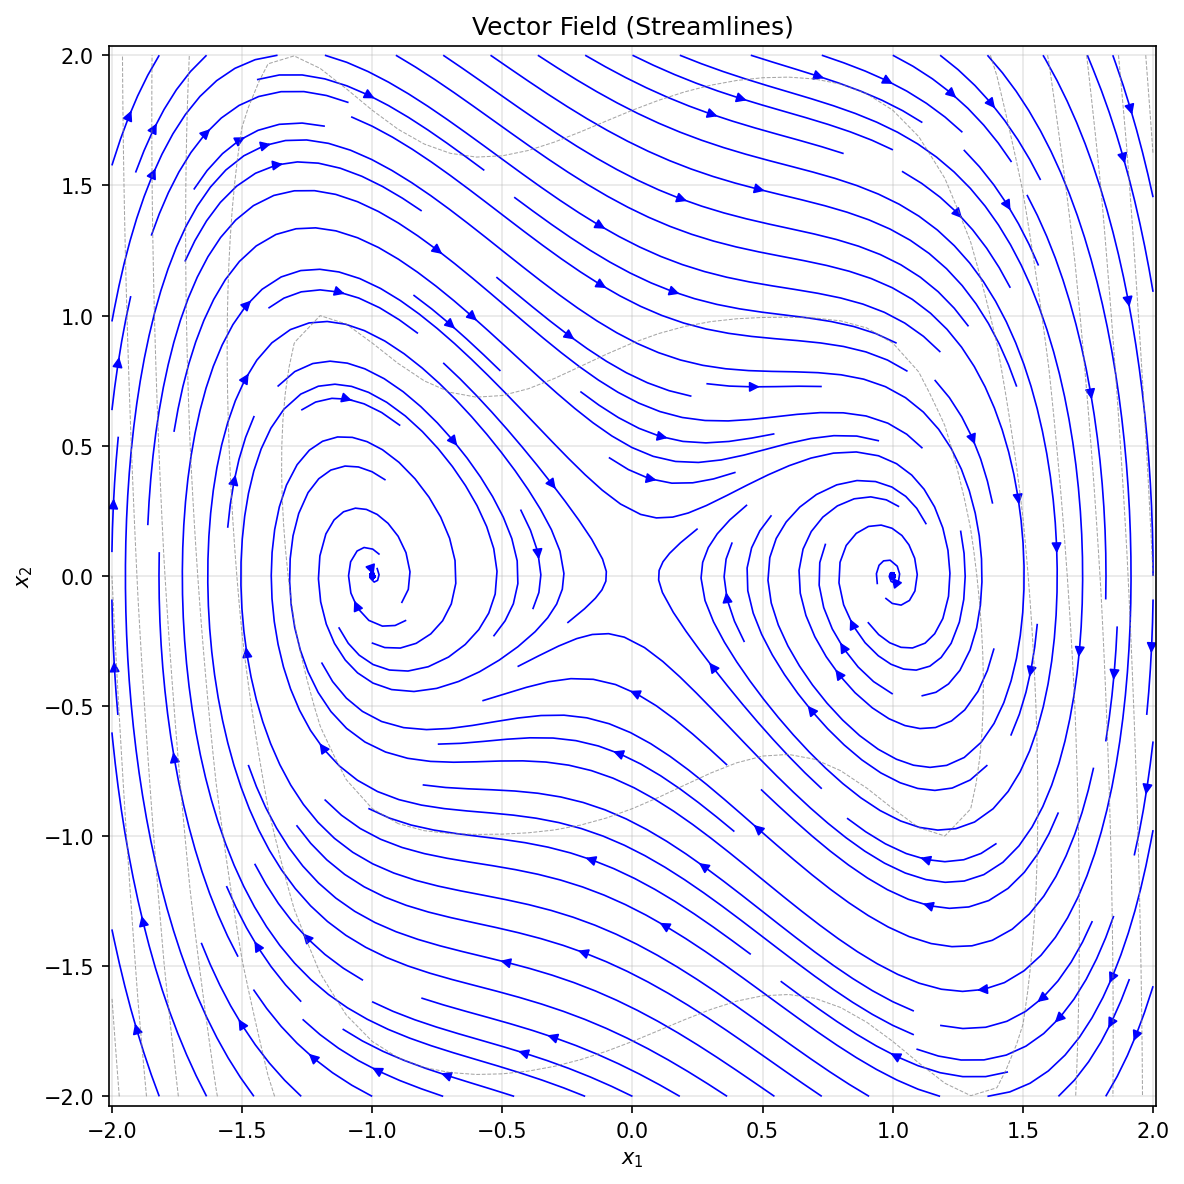

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [18]:
# define the dynamical system
duffing_oscillator = ddrv.dynamic.DuffingOscillator()
ddrv.viz.vis_vector_field_2d(
    duffing_oscillator.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    step_size=0.1,
)

generated 1000 trajectories in batch (odeint), 100 steps, 0.03 time step...
(101, 1000, 2)


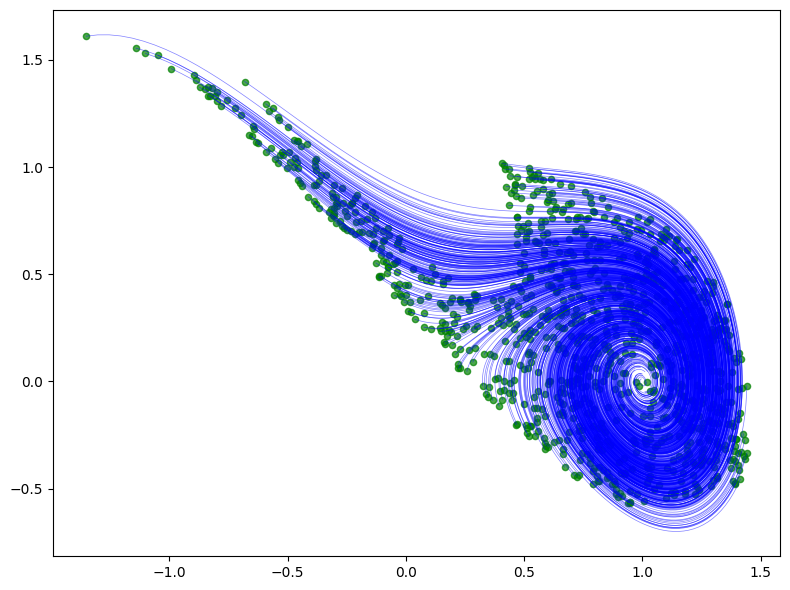

In [19]:
# set the seed for reproducibility
RANDOM_SEED = 0
DT = 0.03

# generate the backward trajectory data
traj_data = ddrv.common.generate_trajectory_data(
    duffing_oscillator,
    domain=[[0.7, 1.3], [-0.3, 0.3]],
    num_samples=1000,
    num_steps=100,
    dt=DT,
    forward=False,
    random_seed=RANDOM_SEED,
)
print(traj_data.shape)
# flip the backward trajectory data to forward
traj_data = traj_data[::-1, :, :]

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)
# now the trajectory data is only from the domain of one specific attractor

In [20]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(100000, 2) (100000, 2)


In [21]:
# apply the resdmd algorithm


LAM, V, residuals, observables, PX, PY, K = ddrv.algo.resdmd(
    X, Y, observe_params={"basis": "poly", "degree": 16}
)

print(
    LAM.shape,
    V.shape,
    residuals.shape,
    observables.shape,
    PX.shape,
    PY.shape,
    K.shape,
)

threshold = 1e-4  # threshold of residuals for selecting the feasible eigenpairs
# get the eigenvalues and eigenvectors with residuals less than the threshold
idx_candidates = np.where(residuals < threshold)[0]
# sort the indices by residuals from smallest to largest
idx = idx_candidates[np.argsort(residuals[idx_candidates])]
print(idx, "idx")

LAM_feasible_dt = LAM[idx]  #  these are discrete eigenvalues
# get the continuous eigenvalues
LAM_feasible_ct = np.log(LAM_feasible_dt) / DT
V_feasible = V[:, idx].T
print(LAM_feasible_dt.shape, V_feasible.shape)
print(LAM_feasible_ct, "LAM_feasible_ct")
print(residuals[idx], "residuals[idx]")

(153,) (153, 153) (153,) (2, 153) (100000, 153) (100000, 153) (153, 153)
[ 80  48  47  61  31  32  42  41  21  22  85  51  52 106  91  90  77  76
  68  69  93  92  34  33  54  53 100 101  16 104 105  17  18 123 134 133
 128 117 118 111 112   7   6 119 120 124 125 113 114] idx
(49,) (49, 153)
[-2.59052039e-14 +0.j         -1.15552058e+01 -1.11928327j
 -1.15552058e+01 +1.11928327j -8.76557480e+00 +0.j
 -1.35652653e+01 +4.76399307j -1.35652653e+01 -4.76399307j
 -1.10691848e+01 -4.19604984j -1.10691848e+01 +4.19604984j
 -1.43689545e+01 +8.18388285j -1.43689545e+01 -8.18388285j
 -6.11051599e+00 +0.j         -9.91018009e+00 +1.4227717j
 -9.91018009e+00 -1.4227717j  -5.01215038e-01 +0.j
 -5.80035419e+00 -0.24140504j -5.80035419e+00 +0.24140504j
 -7.07137374e+00 -0.87532166j -7.07137374e+00 +0.87532166j
 -7.28525431e+00 +2.56752151j -7.28525431e+00 -2.56752151j
 -5.00448971e+00 -1.83690842j -5.00448971e+00 +1.83690842j
 -1.15267620e+01 -7.06503496j -1.15267620e+01 +7.06503496j
 -8.55920654e+00

In [22]:
# apply the reachability verification algorithm

# define the initial set, and target set for reachability verification
# X0 = [[-0.8, -0.7], [1.8, 1.9]]
# X0 = [[0.0, 0.2], [0.6, 0.8]]
X0 = [[0.9, 1.0], [-0.7, -0.6]]
# X0 = [[1.4, 1.6], [-0.1, 0.1]]
XF = [[0.6, 0.7], [0.2, 0.3]]
# XF = [[1.0, 1.1], [-0.5, -0.4]]

pts_X0 = ddrv.common.sample_box_set(X0, 5000)
pts_XF = ddrv.common.sample_box_set(XF, 5000)
print(pts_X0.shape, pts_XF.shape)

# evaluate the eigenfunctions on the initial set and target set samples
ef0_vals = observables.eval_mod(pts_X0, V_feasible)
efF_vals = observables.eval_mod(pts_XF, V_feasible)
print(ef0_vals.shape, efF_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(
    ef0_vals, efF_vals, LAM_feasible_ct
)
print(time_bounds, status, "time_bounds & status")

(5000, 2) (5000, 2)
(5000, 49) (5000, 49)
() bound_mag
[] ('UNREACHABLE', 0) time_bounds & status


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


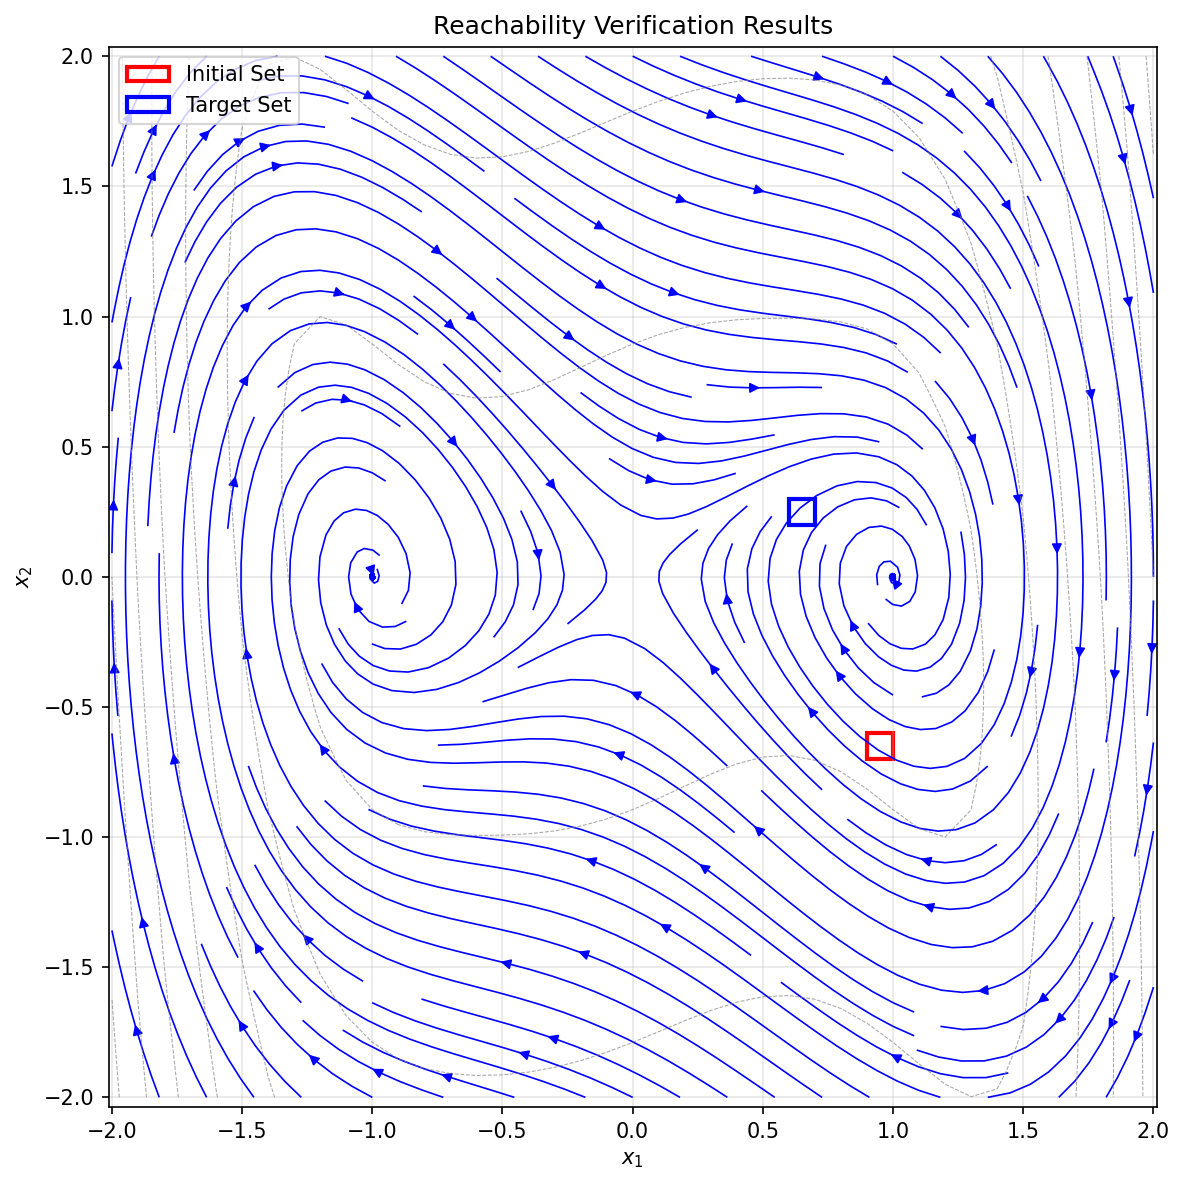

In [23]:
# visualize the reachability result
ddrv.viz.vis_rv(
    duffing_oscillator.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    bounds=time_bounds,
    dt=0.01,
    initial_set=X0,
    target_set=XF,
)